# HW2
### Layan Abu Sinni && Lana Yaqoub

In [1]:
!pip install textblob
!pip install vaderSentiment

## Libraries

In [2]:
import re
from textblob import TextBlob
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import os
from sklearn.model_selection import train_test_split, cross_val_score
import numpy as np
import sys
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score
import subprocess
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import string
from collections import Counter
from itertools import chain
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tabulate import tabulate
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
sid = SentimentIntensityAnalyzer()
lemmatizer = WordNetLemmatizer()
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import classification_report, confusion_matrix

## Import Data

In [3]:
train = pd.read_csv('Train.csv', encoding='latin1')
test = pd.read_csv('Test.csv', encoding='latin1')
positive_words = pd.read_csv('positive_words.csv', encoding='latin1')
negative_words = pd.read_csv('negative_words.csv', encoding='latin1')
positive_words = set(positive_words['Positive Words'])
negative_words = set(negative_words['Negative Words'])

## Pre Processing

#### Removing Usernames from Sentiment Text

In [4]:
train['SentimentText'] = train['SentimentText'].apply(lambda x: re.sub(r'@[A-Za-z0-9_]+!?', '', x)) 

#### Removing URLs from Sentiment Text

In [5]:
train['SentimentText'] = train['SentimentText'].apply(lambda x: re.sub(r'http\S+', '', x)) 

#### Removing Digits from Sentiment Text

In [6]:
train['SentimentText'] = train['SentimentText'].apply(lambda x: re.sub(r'\d+', '', x).lower())

## EDA

#### Analyzing Sentiment Distribution
##### Understanding sentiment distribution (0s and 1s) helps identify data imbalances, informs modeling strategies, and provides insights into user perceptions.

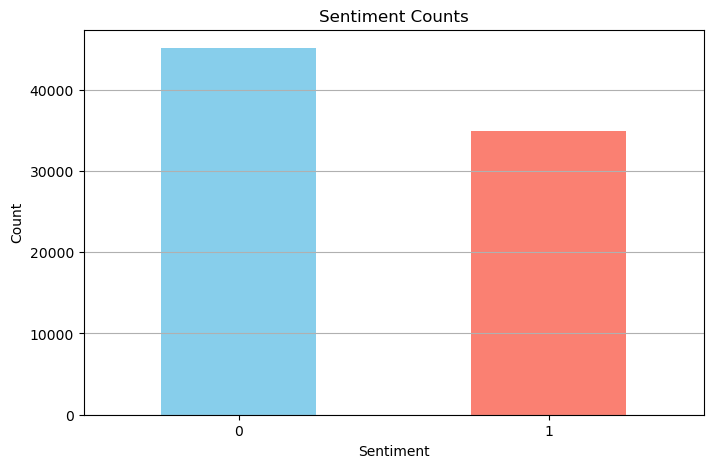

In [7]:
sentiment_counts = train['Sentiment'].value_counts()
plt.figure(figsize=(8, 5))
sentiment_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Sentiment Counts')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['0', '1'], rotation=0)
plt.grid(axis='y')
plt.show()

#### Missing Value Analysis
##### Knowing where data is missing is important because it can affect the model’s performance.

In [8]:
missing_values = train.isnull().sum()
empty_values = (train == '').sum()

missing_data = pd.DataFrame({
    'Missing': missing_values,
    'Empty': empty_values
}).fillna(0)

missing_data

,Missing,Empty
Sentiment,0,0
SentimentText,0,0


#### Text Length Distribution
##### This helps us see if shorter or longer texts are more common in the data.

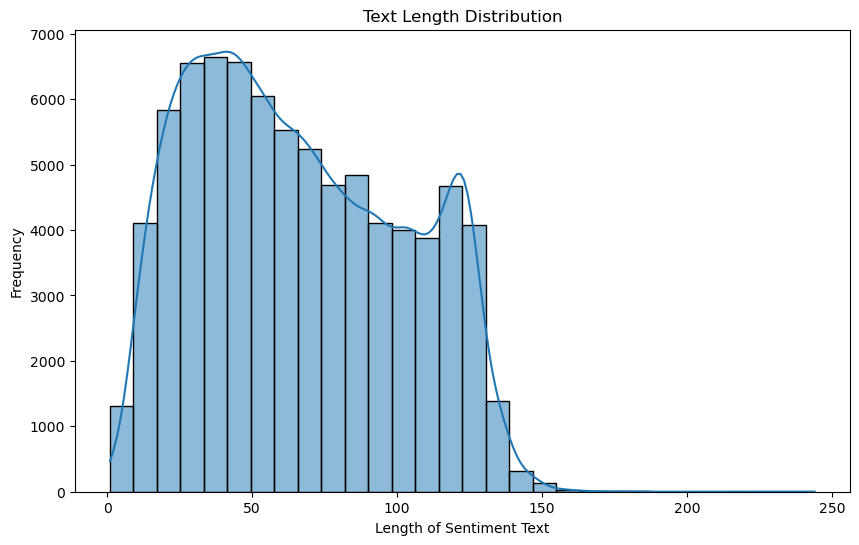

In [9]:
train['TextLength'] = train['SentimentText'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(train['TextLength'], bins=30, kde=True)
plt.title('Text Length Distribution')
plt.xlabel('Length of Sentiment Text')
plt.ylabel('Frequency')
plt.show()

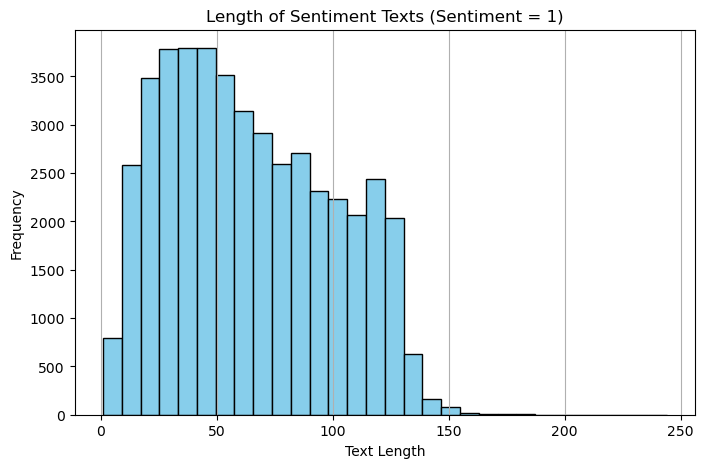

In [10]:
lengths_of_sentiment_texts = train.loc[train['Sentiment'] == 1, 'SentimentText'].str.len()
plt.figure(figsize=(8, 5))
lengths_of_sentiment_texts.hist(bins=30, color='skyblue', edgecolor='black')
plt.title('Length of Sentiment Texts (Sentiment = 1)')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

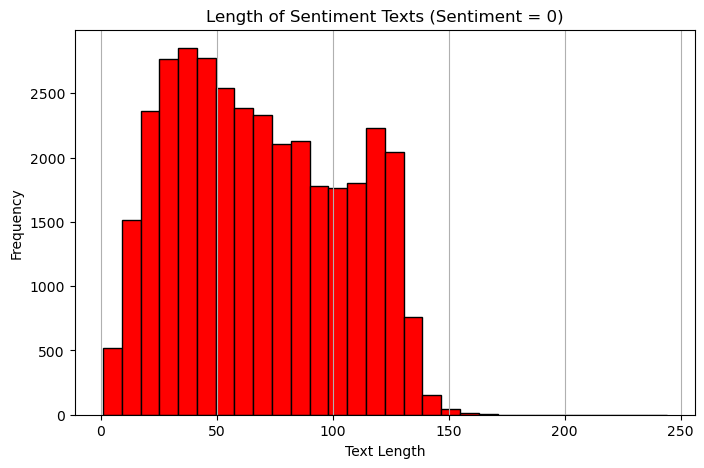

In [11]:
lengths_of_sentiment_texts = train.loc[train['Sentiment'] == 0, 'SentimentText'].str.len()
plt.figure(figsize=(8, 5))
lengths_of_sentiment_texts.hist(bins=30, color='red', edgecolor='black')
plt.title('Length of Sentiment Texts (Sentiment = 0)')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

#### Frequent Words
##### Word clouds visually show the most common words used in each sentiment category.

<Figure size 1000x600 with 0 Axes>

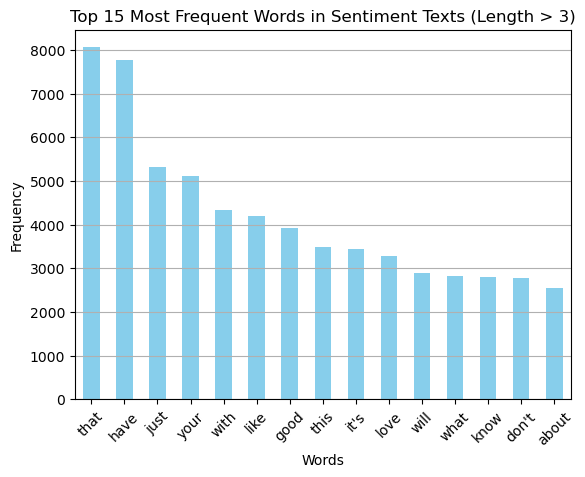

In [12]:
cleaned_train = train.copy()
cleaned_train['CleanedSentimentText'] = cleaned_train['SentimentText'].apply(
    lambda x: ' '.join([word for word in x.lower().split() if len(word) > 3])
)
all_words = ' '.join(cleaned_train['CleanedSentimentText']).lower().split()
word_counts = Counter(all_words)
word_freq = pd.DataFrame(word_counts.items(), columns=['Word', 'Frequency'])
word_freq = word_freq.sort_values(by='Frequency', ascending=False)
plt.figure(figsize=(10, 6))
word_freq.head(15).plot(kind='bar', x='Word', y='Frequency', legend=False, color='skyblue')
plt.title('Top 15 Most Frequent Words in Sentiment Texts (Length > 3)')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

<Figure size 1000x600 with 0 Axes>

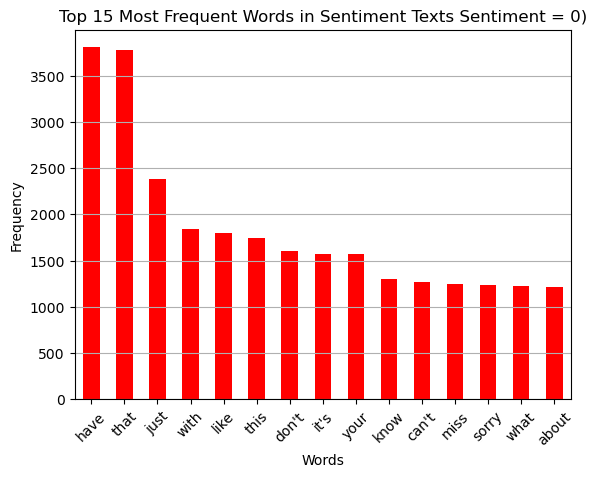

In [13]:
cleaned_train = train.copy()
cleaned_train['CleanedSentimentText'] = cleaned_train['SentimentText'].apply(
    lambda x: ' '.join([word for word in x.lower().split() if len(word) > 3])
)
all_words = ' '.join(cleaned_train[cleaned_train['Sentiment'] == 0]['CleanedSentimentText']).lower().split()
word_counts = Counter(all_words)
word_freq = pd.DataFrame(word_counts.items(), columns=['Word', 'Frequency'])
word_freq = word_freq.sort_values(by='Frequency', ascending=False)
plt.figure(figsize=(10, 6))
word_freq.head(15).plot(kind='bar', x='Word', y='Frequency', legend=False, color='red')
plt.title('Top 15 Most Frequent Words in Sentiment Texts Sentiment = 0)')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

<Figure size 1000x600 with 0 Axes>

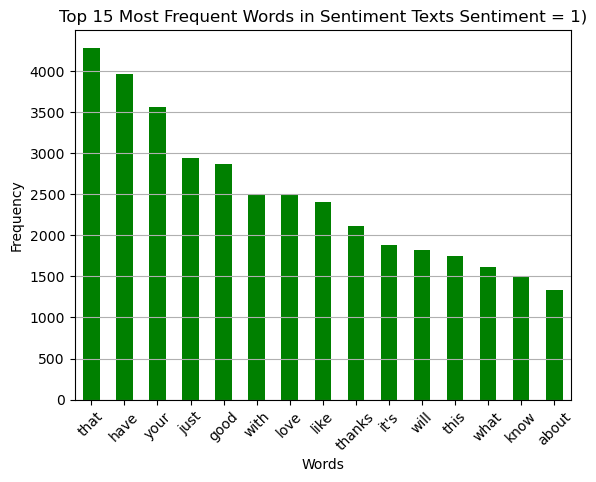

In [14]:
cleaned_train = train.copy()
cleaned_train['CleanedSentimentText'] = cleaned_train['SentimentText'].apply(
    lambda x: ' '.join([word for word in x.lower().split() if len(word) > 3])
)
all_words = ' '.join(cleaned_train[cleaned_train['Sentiment'] == 1]['CleanedSentimentText']).lower().split()
word_counts = Counter(all_words)
word_freq = pd.DataFrame(word_counts.items(), columns=['Word', 'Frequency'])
word_freq = word_freq.sort_values(by='Frequency', ascending=False)
plt.figure(figsize=(10, 6))
word_freq.head(15).plot(kind='bar', x='Word', y='Frequency', legend=False, color='green')
plt.title('Top 15 Most Frequent Words in Sentiment Texts Sentiment = 1)')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

#### Emoji Analysis in Social Media Texts

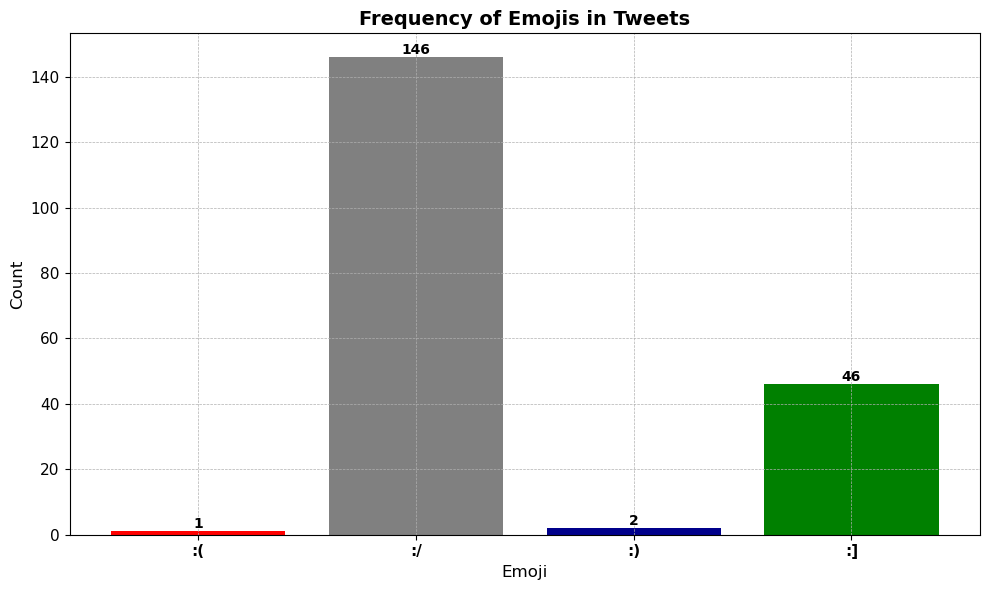

In [15]:
emojis = [':(', ':/', ':-(', ':)', ':D', ':]', ':-)']
escaped_emojis = [re.escape(emoji) for emoji in emojis]
total_counts = Counter()
for emoji in escaped_emojis:
    total_counts[emoji] += train['SentimentText'].str.count(emoji).sum()
emojis_found = [emoji for emoji in emojis if total_counts[re.escape(emoji)] > 0]  # Show only emojis that are found
counts = [total_counts[re.escape(emoji)] for emoji in emojis if total_counts[re.escape(emoji)] > 0]
colors = ['red', 'grey', 'darkblue', 'green', 'orange', 'purple', 'pink']
plt.figure(figsize=(10, 6))
bars = plt.bar(emojis_found, counts, color=colors)
plt.title('Frequency of Emojis in Tweets', fontsize=14, fontweight='bold')
plt.xlabel('Emoji', fontsize=12)
plt.ylabel('Count', fontsize=12)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom', fontweight='bold')
plt.xticks(fontsize=11, fontweight='bold')
plt.yticks(fontsize=11)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

## Feature Extraction

In [16]:
feature_data = {
    "Feature Name": ["TextBlob","VADER","Score based on specific word","Positive Emoticons ","Negative Emoticons "],
    "Type": ["Numeric","Numeric","Numeric","Numeric","Numeric"],
    "Description": ["Sentiment polarity score using TextBlob","Sentiment score using VADER","Custom sentiment score based on specific words","Binary indicator for positive emoticons","Binary indicator for negative emoticons"]
}
print(tabulate(pd.DataFrame(feature_data), headers='keys', tablefmt='pretty', stralign='center', numalign='center'))

+---+------------------------------+---------+------------------------------------------------+
|   |         Feature Name         |  Type   |                  Description                   |
+---+------------------------------+---------+------------------------------------------------+
| 0 |           TextBlob           | Numeric |    Sentiment polarity score using TextBlob     |
| 1 |            VADER             | Numeric |          Sentiment score using VADER           |
| 2 | Score based on specific word | Numeric | Custom sentiment score based on specific words |
| 3 |      Positive Emoticons      | Numeric |    Binary indicator for positive emoticons     |
| 4 |      Negative Emoticons      | Numeric |    Binary indicator for negative emoticons     |
+---+------------------------------+---------+------------------------------------------------+


In [17]:
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

def get_vader_sentiment(text):
    return sid.polarity_scores(text)['compound']

def calculate_sentiment_score(text):
    words = text.lower().split()
    score = 0

    for i in range(len(words) - 1):
        phrase = f"{words[i]} {words[i + 1]}"
        if phrase in negative_words:
            score = score - 2

        elif phrase in positive_words:
            score = score + 2

    for word in words:
        lemma = word
        if lemma in positive_words:
            score += 1
        elif lemma in negative_words:
            score -= 1
    return score

def has_positive_emoticon(text):
    positive_emoticons = [':)', ':D', ':]', ':-)']
    for emoticon in positive_emoticons:
        if emoticon in text:
            return 1
    return 0

def has_negative_emoticon(text):
    negative_emoticons = [':(', ':(', ':/', ':-(']
    for emoticon in negative_emoticons:
        if emoticon in text:
            return 1
    return 0

#### Applying Features on Data

In [18]:
train['TextBlob_Sentiment'] = train['SentimentText'].apply(get_sentiment)
train['Custom_Sentiment'] = train['SentimentText'].apply(calculate_sentiment_score)
train['Vader_Sentiment'] = train['SentimentText'].apply(get_vader_sentiment)
train['Has_Positive_Emoticon'] = train['SentimentText'].apply(has_positive_emoticon)
train['Has_Negative_Emoticon'] = train['SentimentText'].apply(has_negative_emoticon)

#### Finding the Best Parameters for the Model Pipeline

In [19]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('lr', LogisticRegression(random_state=42, max_iter=1000)),
])

parameters = {
    'tfidf__max_features': [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 12000, 15000],
}

grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(train['SentimentText'], train['Sentiment'])

print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'tfidf__max_features': 9000}


#### Transforming Text Data with TF-IDF Vectorization

In [20]:
vectorizer = TfidfVectorizer(max_features = 15000, ngram_range=(1, 2))
train_vector = pd.DataFrame(vectorizer.fit_transform(train['SentimentText']).toarray(), columns=vectorizer.get_feature_names_out())

#### Appending Sentiment Features to the Vectorized Data

In [20]:
train_vector['TextBlob_Sentiment'] = train['TextBlob_Sentiment'].values
train_vector['Custom_Sentiment'] = train['Custom_Sentiment'].values
train_vector['Vader_Sentiment'] = train['Vader_Sentiment'].values
train_vector['Has_Positive_Emoticon'] = train['Has_Positive_Emoticon'].values
train_vector['Has_Negative_Emoticon'] = train['Has_Negative_Emoticon'].values

#### Splitting Data into Train and Test

In [21]:
X = train_vector
y = train['Sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

MemoryError: Unable to allocate 7.15 GiB for an array with shape (63998, 15000) and data type float64

#### Evaluating and Comparing Machine Learning Algorithms for Sentiment Analysis with Cross-Validation

In [ ]:
lr_classifier = LogisticRegression(random_state=42, max_iter=1000)
clf_svc = LinearSVC(random_state=42)
clf_nb = BernoulliNB()

classifiers = [lr_classifier, clf_svc, clf_nb]
classifier_names = ['Logistic Regression', 'Linear SVC', 'Bernoulli Naive Bayes']
cv_results = {'Classifier': [], 'CV Mean Accuracy': [], 'CV Std Accuracy': []}
for clf, name in zip(classifiers, classifier_names):
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
    cv_results['Classifier'].append(name)
    cv_results['CV Mean Accuracy'].append(scores.mean())
    cv_results['CV Std Accuracy'].append(scores.std())
cv_results_df = pd.DataFrame(cv_results)
print(cv_results_df)

lr_classifier.fit(X_train, y_train)
clf_svc.fit(X_train, y_train)
clf_nb.fit(X_train, y_train)

y_pred_lr = lr_classifier.predict(X_test)
y_pred_svc = clf_svc.predict(X_test)
y_pred_nb = clf_nb.predict(X_test)

accuracy_lr = accuracy_score(y_test, y_pred_lr)
accuracy_svc = accuracy_score(y_test, y_pred_svc)
accuracy_nb = accuracy_score(y_test, y_pred_nb)

recall_lr = recall_score(y_test, y_pred_lr, average='weighted')
recall_svc = recall_score(y_test, y_pred_svc, average='weighted')
recall_nb = recall_score(y_test, y_pred_nb, average='weighted')

f1_lr = f1_score(y_test, y_pred_lr, average='weighted')
f1_svc = f1_score(y_test, y_pred_svc, average='weighted')
f1_nb = f1_score(y_test, y_pred_nb, average='weighted')

precision_lr = precision_score(y_test, y_pred_lr, average='weighted')
precision_svc = precision_score(y_test, y_pred_svc, average='weighted')
precision_nb = precision_score(y_test, y_pred_nb, average='weighted')

results = pd.DataFrame({
    'Classifier': ['Logistic Regression', 'Linear SVC', 'Bernoulli Naive Bayes'],
    'Accuracy': [accuracy_lr, accuracy_svc, accuracy_nb],
    'Recall': [recall_lr, recall_svc, recall_nb],
    'F1 Score': [f1_lr, f1_svc, f1_nb],
    'Precision': [precision_lr, precision_svc, precision_nb]
})

results

In [ ]:
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)
conf_matrix_svc = confusion_matrix(y_test, y_pred_svc)
conf_matrix_nb = confusion_matrix(y_test, y_pred_nb)
print("\nConfusion Matrix for Logistic Regression:\n", conf_matrix_lr)
print("\nConfusion Matrix for Linear SVC:\n", conf_matrix_svc)
print("\nConfusion Matrix for Bernoulli Naive Bayes:\n", conf_matrix_nb)

#### Classifier Accuracy Comparison

In [22]:
sns.set(style='whitegrid')
plt.figure(figsize=(10, 6))
colors = sns.color_palette("coolwarm", len(results))
ax = sns.barplot(x='Accuracy', y='Classifier', data=results, palette=colors)
for p in ax.patches:
    ax.annotate(f'{p.get_width():.2f}', (p.get_width(), p.get_y() + p.get_height() / 2),ha='center', va='center', fontsize=12, color='black', xytext=(5, 0), textcoords='offset points')
plt.title('Classifier Accuracy Comparison', fontsize=16, fontweight='bold')
plt.xlim(0, 1)  # Set x-axis limits to show accuracy percentage
plt.xlabel('Accuracy', fontsize=14)
plt.ylabel('Classifiers', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

NameError: name 'results' is not defined

<Figure size 1000x600 with 0 Axes>

##### We evaluated three classifiers: Logistic Regression, Linear SVC, and Bernoulli Naive Bayes. Logistic Regression achieved the highest accuracy on the test dataset. Therefore, we will use it for the real test, as it offers the best classification performance.

#### Classification Report for Logistic Regression

In [25]:
report = classification_report(y_test, y_pred_lr, output_dict=True)
pd.DataFrame(report).transpose()

,precision,recall,f1-score,support
0,0.764955,0.707561,0.735139,6904.00
1,0.789994,0.834982,0.811865,9096.00
accuracy,0.780000,0.780000,0.780000,0.78
macro avg,0.777474,0.771272,0.773502,16000.00
weighted avg,0.779189,0.780000,0.778758,16000.00


## Part 2

#### Applying Pre Processing on Test

In [26]:
test['SentimentText'] = test['SentimentText'].apply(lambda x: re.sub(r'@[A-Za-z0-9_]+!?', '', x))  
test['SentimentText'] = test['SentimentText'].apply(lambda x: re.sub(r'http\S+', '', x)) 
test['SentimentText'] = test['SentimentText'].apply(lambda x: x.lower()) 
test['SentimentText'] = test['SentimentText'].apply(lambda x: re.sub(r'\s+', ' ', x).strip()) 
test['SentimentText'] = test['SentimentText'].apply(lambda x: re.sub(r'\d+', '', x).lower())

#### Applying Features on Test

In [27]:
test['TextBlob_Sentiment'] = test['SentimentText'].apply(get_sentiment)
test['Custom_Sentiment'] = test['SentimentText'].apply(calculate_sentiment_score)
test['Vader_Sentiment'] = test['SentimentText'].apply(get_vader_sentiment)
test['Has_Positive_Emoticon'] = test['SentimentText'].apply(has_positive_emoticon)
test['Has_Negative_Emoticon'] = test['SentimentText'].apply(has_negative_emoticon)

#### Transforming Test Data into Feature Vectors

In [28]:
test_vector = pd.DataFrame(vectorizer.transform(test['SentimentText']).toarray(), columns=vectorizer.get_feature_names_out())

#### Appending Sentiment Features to the Vectorized Test Data

In [29]:
test_vector['TextBlob_Sentiment'] = test['TextBlob_Sentiment'].values
test_vector['Custom_Sentiment'] = test['Custom_Sentiment'].values
test_vector['Vader_Sentiment'] = test['Vader_Sentiment'].values
test_vector['Has_Positive_Emoticon'] = test['Has_Positive_Emoticon'].values
test_vector['Has_Negative_Emoticon'] = test['Has_Negative_Emoticon'].values

#### Splitting Data into Train and Test

In [30]:
X_train = X
y_train = y
X_test = test_vector

#### Training and Predicting with Logistic Regression Classifier

In [ ]:
lr_classifier = LogisticRegression(random_state=42, max_iter=1000)
lr_classifier.fit(X_train, y_train)
y_pred = lr_classifier.predict(X_test)

#### Creating and Saving Submission File for Predictions

In [ ]:
predict = pd.DataFrame({'ID': test['ID'], 'Sentiment': y_pred})
predict.to_csv('predict1099.csv', index=False)